Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 12
83.33% done (9/12 completed)
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\benlc\PASP_HCItutorial-main\KLIP_Processing\Dec_2023
wavelength collapsing reduced data of shape (b, N, wv, y, x):(4, 99, 1, 1024, 1024)


TypeError: 'NoneType' object is not subscriptable

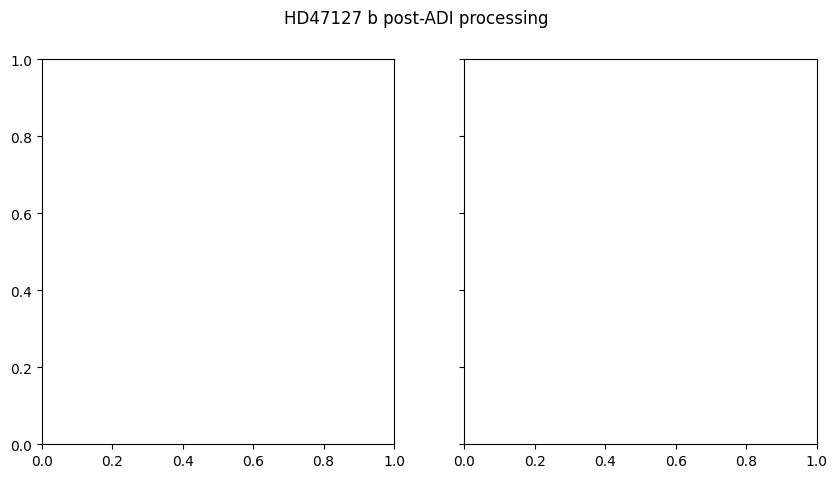

In [2]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
import pyklip
import pyklip.klip as klip
import pyklip.parallelized as parallelized
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.instruments.Instrument import GenericData
import astropy.units as u
from importlib import reload
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
%matplotlib inline

#define functions for display
def add_label(ax,txt,imsz):
    ax.text(5,imsz-10,txt,c='w',size=18)
    
def add_cbar(im,ax,f,lb="counts"):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%',pad=0.05)
    f.colorbar(im,cax=cax,orientation='vertical',label=lb)
    
def set_display(stampsz,stampcen,tickint=1):
    mnx=int(stampcen[0]-stampsz/2)
    mxx=int(stampcen[0]+stampsz/2+1)
    mny=int(stampcen[1]-stampsz/2)
    mxy=int(stampcen[1]+stampsz/2+1)
    ranges=(mnx,mxx,mny,mxy)
    platescale=.009971 ###for GPI its .01414
    nticks=np.floor(stampsz*platescale/2/tickint)
    ticklabels=np.arange(-1*nticks,nticks+1)*tickint
    ticklabels_str=[str(lab)+'\"' for lab in ticklabels]
    ticks = ticklabels/platescale + stampsz/2
    return(ranges,ticks,ticklabels_str)
warnings.filterwarnings("ignore")



#classical ADI
#   subtract median arrays as PSF, rotate images and take the median




def cADI_NIRC2(flist):
    
    #get data from fits, create raw image arrays
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))#ctrs[0]
            #print(ctrs[0]) #plot,, find center from first
            
            #check each centroid post-cross-correlation
            aligned_cube[0,:,:] = rawcube[0,:,:]
            print(head)
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            #print(shifts)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrPoisson[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va) ##check paper
        #print(vertangs[i])
    
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    #plt.plot(ctrs)
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    return SNR_map, med_derot, ctrs[0]

#ADI
def ADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    imgs = np.zeros((len(flist),1024,1024))
    ctrs= np.zeros((len(flist),2))
    parangs=np.zeros((len(flist)))
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        #find centers
        if i == 0:
            ctrs[i][0] = 611.4
            ctrs[i][1] = 436.2
        else:
            shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
                                                    upsample_factor=100,
                                                    normalization=None)
            ctrs[i][0] = ctrs[0][0] - shifts[0]
            ctrs[i][1] = ctrs[0][1] - shifts[1]##this allows the centers to be different, just to see what pyklip will do -- alternative is to make an N length array with every element equalling the first ctrs[0]
            
        #find parangs
        parangs[i]=head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        imgs[i,:,:] = np.flip(rawcube[i,:,:],axis=(0,1)) #"array of 2D images for ADI. Shape of array (N,y,x)"
        
            
    dataset = GenericData(rawcube, ctrs, IWA=6, parangs=parangs)
    sub_imgs = parallelized.klip_dataset(dataset, outputdir='KLIP_Processing/Dec_2023',
                                        annuli=3,subsections=4,numbasis=[1,20,50,100],maxnumbasis=150,mode="ADI",
                                        movement=1)
    """sub_imgs = parallelized.klip_parallelized(imgs=imgs, centers=ctrs, 
                                              parangs=parangs, IWA=10, 
                                              filenums=np.arange(0,len(flist)), 
                                              mode='ADI', wvs=None,
                                              numbasis = [1,20,50,100])"""
        
    #sub_imgs = parallelized.klip_dataset(imgs,mode='ADI')
    return sub_imgs, ctrs[i]
   



datadir='HD47127_data/Dec_2023/'
#datadir = 'HD47127_data/Feb_2023/'
flist = sorted(glob.glob(datadir + '*.fits'))

#flist_adi, med, cen = cADI_NIRC2(flist)
flist_adi, cen = ADI_NIRC2(flist)
stampsz = 600
rg, ticks, ticklabels_str = set_display(stampsz, stampcen=cen)
(mnx,mxx,mny,mxy) = rg


f,(ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
f.suptitle("HD47127 b post-ADI processing")
im1 = ax1.imshow(flist_adi[mny:mxy,mnx:mxx],origin='lower')
im2 = ax2.imshow(med[mny:mxy,mnx:mxx],origin='lower')
plt.xticks(ticks,labels=ticklabels_str)
plt.yticks(ticks,labels=ticklabels_str)
add_cbar(im1,ax1,f)
add_cbar(im2,ax2,f)

#NAXIS: num of axes
#NAXIS1: length of axis
#RA
#DEC
#TARGRA
#TARGDEC
#RAOFF, DECOFF: DCS RA, Dec offset
#PARANG: parallactic angle astrometric
#CENWAVE: central wavelength of passband
#MINWAVE, MAXWAVE
#EFFWAVE: effective wavelength of passband
#LTM1_1, LTM2_2, CD1_1, CD1_2, CD2_1, CD2_2
#ELAPTIME: total integration time
#PSFCX, PSFCY: center of PSF in pixels
#STARCX, STARCY: center of star in pixels
#PIXSCALE, PIXSCAL1, PIXSCAL2: arcsec per pixel

#KLIP/PCA LATER!!
#position + brightness of companion

#KLIP + FM
